### Disease name degeneracy 
A disease name is written in different ways in research articles or in documents.  This creates interest to explore the degeneracy in disease name. The data used in this analysis were generated using the [program](https://github.com/exchhattu/BiomedicaLorHealthCare-NLP).

In [1]:
import numpy as np

In [2]:
def parse_gs_dner_file(path_to_file):
  ts_word_diffs = []
  with open(path_to_file, "r") as fo_read:
    ts_lines = fo_read.read().split("\n")
    for st_line in ts_lines:
      if st_line.startswith("WordsPerDisease"):
        # only first two columns are required
        ts_columns = st_line.replace("WordsPerDisease: ", "").split(",")[:2]
        ts_word_diffs.append(int(ts_columns[1]))
  
  hist, hist_edge = np.histogram(np.array(ts_word_diffs), bins= np.arange(1, 11, 1))
  #print(len(hist), len(hist_edge))
  if len(ts_word_diffs) > np.sum(hist):
    ts_mhist = list(hist)
    ts_mhist.append(len(ts_word_diffs) - np.sum(hist))
    ts_mhist_edge = list(hist_edge)
    ts_mhist_edge.append(">10")
    
    hist, hist_edge = ts_mhist, ts_mhist_edge
    #print(hist)
    #print(hist_edge)
  return hist, hist_edge 

In [3]:
tu_NCBI_gs = parse_gs_dner_file("./data/NCBI_disease_corpus/NCBI_corpus_gs.out")
tu_CDR_gs  = parse_gs_dner_file("./data/CDR/CDR_gs.out")

In [4]:
import pandas as pd
Xs        = []
X_values  = tu_NCBI_gs[1] # both data have same X-axis

for i in range(0, len(tu_NCBI_gs[1])-1):
  Xs.append("%s" %X_values[i])
Xs[-1] = ">10"

# Normalize
Y1_values = np.array(tu_NCBI_gs[0])/np.sum(np.array(tu_NCBI_gs[0]))
Y2_values = tu_CDR_gs[0] /np.sum(tu_CDR_gs[0])

# Convert numpy array in data frame
df_data = pd.DataFrame({"Xs": Xs})
df_data["NCBIDisease"] = pd.Series(Y1_values)
df_data["CDR"] = pd.Series(Y2_values)

#### Distribution of naming degeneracy in disease name entity recoginition

Using manually curated data, I explored the distributions from two studies. Notably, both studies showed a similar distribution. The majority of diseases (>50%) were represented by only one name followed by 20% with two names. However, there are  30% of disease entities for which multiple names were referred to represent the same disease.  

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

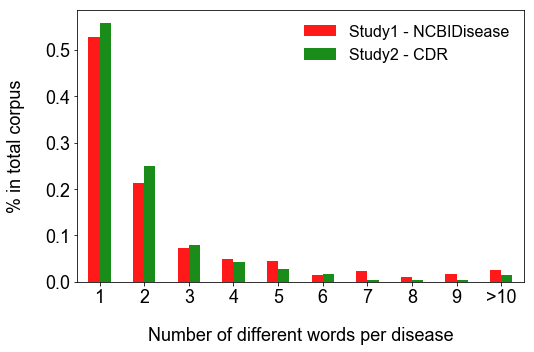

In [6]:
fig  = plt.figure(figsize=(8, 5))
ax   = fig.add_subplot(111)
df_data.plot(x='Xs', y=['NCBIDisease', 'CDR'], kind="bar", \
             ax=ax, color=["r", "g"], label=["Study1 - NCBIDisease", "Study2 - CDR"], \
             alpha=0.9, legend=True, rot=0)
ax.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Number of different words per disease", axis_font, labelpad=20)
ax.set_ylabel("% in total corpus", axis_font, labelpad=20)
plt.legend(ncol=1, loc="upper right", prop={'size':16}, frameon=False)
plt.show()

### Extensively observed diseases
To identify the extensively studied diseases, the proportion of each disease was obtained from the entire corpus of two studies. Afterward, the z-score was independently computed for each study and ranked them based on how far they are from the mean.

In [7]:
def parse_gs_dner_unique_dcount(path_to_file):
  ts_unique_diseases = []
  with open(path_to_file, "r") as fo_read:
    ts_lines = fo_read.read().split("\n")
    for st_line in ts_lines:
      if st_line.startswith("UniqueDiseaseCount:"):
        # only first two columns are required
        ts_columns = st_line.replace("UniqueDiseaseCount: ", "").split(",")
        # print(ts_columns)
        ts_unique_diseases.append(int(ts_columns[1]))
  
  ar_data = np.array(ts_unique_diseases)
  ar_abs_data = np.abs((ar_data - np.mean(ar_data))/np.std(ar_data))
  return np.sort(ar_abs_data)

In [8]:
ncbi_zscore = parse_gs_dner_unique_dcount("./data/NCBI_disease_corpus/NCBI_corpus_gs.out")
cdr_zscore  = parse_gs_dner_unique_dcount("./data/CDR/CDR_gs.out")

In [9]:
df_zscores = pd.DataFrame({})
df_zscores["NCBIDisease"] = pd.Series(ncbi_zscore[-10:])
df_zscores["CDR"]  = pd.Series(cdr_zscore[-10:])

In [10]:
df_zscores_top20 = df_zscores.sort_values("NCBIDisease", ascending=False)
df_zscores_top20["XaxisLabel"] = np.arange(1, 11, 1, dtype=int)

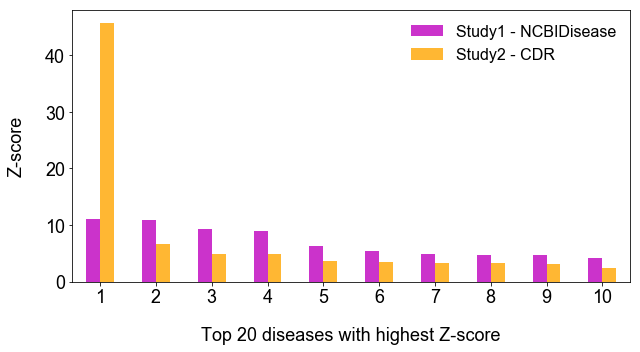

In [11]:
fig  = plt.figure(figsize=(10, 5))
ax   = fig.add_subplot(111)
df_zscores_top20.plot(x='XaxisLabel', y=['NCBIDisease', 'CDR'], kind="bar", \
                      ax=ax, color=["m", "orange"], label=["Study1 - NCBIDisease", "Study2 - CDR"], \
                      alpha=0.8, legend=True, rot=0)
ax.tick_params(axis="both", labelsize=18)
ax.set_xlabel("Top 20 diseases with highest Z-score", axis_font, labelpad=20)
ax.set_ylabel("Z-score", axis_font, labelpad=20)
plt.legend(ncol=1, loc="upper right", prop={'size':16}, frameon=False)
plt.show()

Looking at the top 10 positions, some diseases are highly studied in both cases. The highest one observed is almost 45 and 10 times away from mean in CDR and in NCBIDisease respectively. Cancer, congenital myotonic dystrophy, and familial adenomatous polyposis coli are mostly dominated in the NCBIdisease study whereas clonic fits and acute renal artery thrombosis mostly observed in CDR study. So far, these two conclusions were identified. First, both studies represent the tiny proportion of the entire corpus available in public databases. Second, mostly observed diseases they listed were not overlapped.